# RBM vs cRBM

### TO DO
- Compare Bernoulli, Gaussian and dReLu potentials in performance -->
- learning rate decay
- plot log-likelihood vs epochs
- produce weight features after training (infering) with and without spars penalty





In [1]:
import matplotlib.pyplot as plt
import torch
import scipy.io

import sys
sys.path.append('D:\RU\OneDrive\Intern\Master\RBMs\Codes')

from RBMs_works import RBMs
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


torch.manual_seed(0)
torch.cuda.manual_seed(0)

### Set parameters of RBM and cRBM

In [2]:
# RBM
n_hid = 16 # number of neurons in the hidden layer
n_vis = 256 # input size
n_batches_train = 2000 # number of batches to train on
n_batches_test = 880 # number of batches to test on

lr = 0.01 # learning rate
momentum = 0.9
weightcost = 0.0002
CDk = 10
n_epochs = 1000
batch_size = 64

#cRBM
spars_penalty = 3e-4 #they use in 'Emergence of Compositional Representations in Restricted Boltzmann Machines'
x = 2 # 2 they use in 'Emergence of Compositional Representations in Restricted Boltzmann Machines'


Load data

<AxesSubplot:>

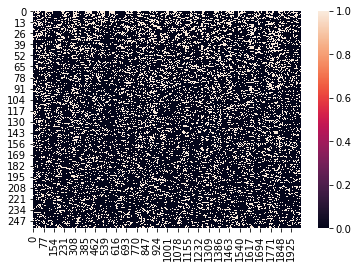

In [3]:
from loaddata import load_data
spikes, behavior, coords, df, stimulus = load_data()

spike_thres = 0.15
spikes[spikes>spike_thres] = 1
spikes[spikes<spike_thres] = 0
tmp = np.argsort(np.sum(spikes,0))[::-1]
spikes = spikes[:,tmp]
spikes = spikes.T
    
data = torch.tensor(spikes[:n_vis, :n_batches_train])

#rbm = RBM(N_V=n_vis, N_H=n_hid, k=1)
#model = train(rbm, data, n_epochs = n_epochs)
#mat = scipy.io.loadmat('D:\RU\OneDrive\Intern\MyCodes\data/bouncing_balls.mat')
#data = torch.tensor(mat['data'], dtype = torch.double)
#n_vis = data.shape[0]*data.shape[1]
#n_hid = 8
#data.shape
sns.heatmap(data)

### Create a (compositional) Restricted Boltzmann Machine

train RBM

In [6]:
n_epochs = 100
RBM = RBMs(data, N_H=n_hid)

RBM.train_RBM(RBM, data,
               n_epochs = n_epochs,
               learning_rate = 0.001,
               momentum = 0.9, 
               weightcost = 0.0002, 
               CDk = 10, PCD = False,
               batchsize = 128,
               disable_tqdm = False)

plt.plot(cRBM.errors) 
plt.xlabel("Number of epochs")
plt.ylabel("RMS error")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


NameError: name 'cRBM' is not defined

train cRBM

In [ ]:
n_epochs = 100
cRBM = RBMs(data, N_H=n_hid)

cRBM.train_cRBM(cRBM, data,
               n_epochs = n_epochs,
               learning_rate = 0.001, learning_rate_decay = True,
               momentum = 0.9, 
               weightcost = 0.0002, 
               CDk = 10, PCD = False,
               spars_penalty = 0.0002, x = 1,
               batchsize = 128,
               disable_tqdm = False)

plt.plot(cRBM.errors) 
plt.xlabel("Number of epochs")
plt.ylabel("RMS error")

In [ ]:
sns.heatmap(RBM.W)
plt.ylabel("Visible nodes")
plt.xlabel("Hidden nodes")
plt.title('RBM')
plt.show()

th=0.001
print('Sparcity W: \t' , float(((RBM.W.ravel()<th) & (RBM.W.ravel()>-th)).sum()/(RBM.W.shape[0]*RBM.W.shape[1])) )

In [ ]:
sns.heatmap(cRBM.W)
plt.ylabel("Visible nodes")
plt.xlabel("Hidden nodes")
plt.title('cRBM')
plt.show()
print('Sparcity W: \t' , float(((cRBM.W.ravel()<th) & (cRBM.W.ravel()>-th)).sum()/(cRBM.W.shape[0]*cRBM.W.shape[1])) )

In [ ]:
def pairwise_interaction(W):
    # W.shape = [V, H]
    return  torch.outer(torch.sum(W,1), torch.sum(W,1))

sns.heatmap(pairwise_interaction(cRBM.W))
plt.ylabel("Visible nodes")
plt.xlabel("Visible nodes")
plt.title('cRBM')
plt.show()

h, _ = cRBM.visible_to_hidden(data.T)
def effective_coupling(W, h):
    return  torch.outer(torch.sum(W,1), torch.sum(W * torch.reshape(torch.var(h,1).repeat(N_V), [N_V, N_H] ),1))


### cRBM hyperparameter optimization by cross-validation

In [ ]:
from plots import *

In [ ]:
plot_weights_log_distribution_compare(RBM.W, cRBM.W, label1='RBM', label2='cRBM', ymin=10e-6, ymax=1000)

In [ ]:
plot_weights_log_distribution(cRBM.W)

What if we apply the same sparity regulation mechanism to the RTRBM or RTcRBM????????

In [ ]:
import sys
sys.path.append('D:\RU\OneDrive\Intern\MyCodes\project')
from RTRBM_batches import RTRBM
N_V = 1024
N_H = 20
print(spikes.shape)
V = torch.tensor(spikes[:N_V, :])
V = V[torch.randperm(N_V),:]


In [ ]:
rtcrbm = RTRBM(V)
rtrbm = RTRBM(V)

maxepoch = 100
rtcrbm.learn(N_H = N_H, 
            mean_field = 'False',
            spars_penalty = 3e-5, x = 2, sp = 'True',
            activationFunction = torch.sigmoid,
            learning_rate = 0.01,  learning_rate_decay = True,
            momentum = 0.9, 
            weightcost = 0.0002, 
            CDk = 10, 
            maxepoch = maxepoch,
            disable_tqdm = False)

rtrbm.learn(N_H = N_H, 
            mean_field = 'False',
            spars_penalty = 0, x = 0, sp = 'False',
            activationFunction = torch.sigmoid,
            learning_rate = 0.01,  learning_rate_decay = True,
            momentum = 0.9, 
            weightcost = 0.0002, 
            CDk = 10, 
            maxepoch = maxepoch,
            disable_tqdm = False)

plt.semilogy(np.linspace(1,maxepoch,maxepoch), torch.reshape(rtcrbm.errors,[maxepoch])) 
plt.xlabel("Number of epochs")
plt.ylabel("RMS error")
plt.title('RTcRBM')

plt.show()  

plt.semilogy(np.linspace(1,maxepoch,maxepoch), torch.reshape(rtrbm.errors,[maxepoch])) 
plt.xlabel("Number of epochs")
plt.ylabel("RMS error")
plt.title('RTRBM')
plt.show() 

In [ ]:
def sparcity(w, threshold, title):
    
    sns.heatmap(w)
    plt.ylabel("Visible nodes")
    plt.xlabel("Hidden nodes")
    plt.title(title)
    plt.show()

    th=threshold
    print('Sparcity:\t' , float(((w.ravel()<th) & (w.ravel()>-th)).sum()/(w.shape[0]*w.shape[1])) )

    
sparcity(rtcrbm.W, 0.0001, 'RTcRBM VH')
sparcity(rtrbm.W, 0.0001, 'RTRBM VH')

sparcity(rtcrbm.W_acc, 0.0001, 'RTcRBM HH')
sparcity(rtrbm.W_acc, 0.0001, 'RTRBM HH')

In [ ]:
plot_weights_log_distribution_compare(rtrbm.W, rtcrbm.W, label1='RTRBM VH', label2='RTcRBM VH', ymin=10e-6, ymax=150)

In [ ]:
plot_weights_log_distribution_compare(rtrbm.W_acc, rtcrbm.W_acc, label1='RTRBM HH', label2='RTcRBM HH', ymin=10e-6, ymax=150)